# RiFNetII

## Import libraries

In [1]:
import os
import glob
import random
import math
import shutil
import numpy as np
from natsort import natsorted

In [2]:
source_dir = r'C:\Users\vibane\Desktop\Victor\Victor_ML\data_merged'
target_dir = r'C:\Users\vibane\Desktop\Victor\Victor_ML\data_merged_ready'

## Create single dataset

In [3]:
classes = os.listdir(source_dir)
if '.DS_Store' in classes:
    classes.remove('.DS_Store')
classes = natsorted(classes)
print(classes)

['displaced', 'no_fracture', 'nondisplaced']


In [5]:
def create_images(cand_pack, imgsave_path, file_prefix):
    
    cnt = 1
    cand_unpack = [item for sublist in cand_pack for item in sublist]

    for filename in cand_unpack:

        #new_filename = os.path.join(imgsave_path, '{0}_{1}.jpg'.format(file_prefix, cnt))
        new_filename = os.path.join(imgsave_path, filename)
        filepath = os.path.join(source_dir,file_prefix,filename)
        shutil.copy(filepath, new_filename)

        cnt += 1


In [4]:
def pack(candidates):
    
    cand_pack = []
    fracture = []
    
    for c in range(len(candidates)-1):
        
        name = candidates[c].split('.')[0].split('_')[-2]
        name2 = candidates[c+1].split('.')[0].split('_')[-2]
        
        if c == len(candidates)-2:
            fracture.append(candidates[c])
            fracture.append(candidates[c+1])
            cand_pack.append(fracture)
            fracture = []
            
        if int(name) < int(name2):
            fracture.append(candidates[c])
            
        else:
            fracture.append(candidates[c])
            cand_pack.append(fracture)
            fracture = []
            
    return cand_pack
            
        

In [7]:
def process(dist_training, dist_test, dist_validation):
    
    distributions = {'training': dist_training, 'test': dist_test, 'validation': dist_validation}
    
    for cl in classes:
        
        print('current class:',cl)
        
        candidates = natsorted(os.listdir(os.path.join(source_dir, cl)))
        if '.DS_Store' in candidates:
            candidates = candidates[1:]
            
        cand_pack = pack(candidates)
    
        offset = 0
        
        for key, percentage in distributions.items(): 
            
            share = math.floor(len(cand_pack) / 100 * percentage)
  
            class_path = os.path.join(target_dir, key, cl)
            if not os.path.isdir(class_path): 
                os.makedirs(class_path)
    
            create_images(cand_pack[offset:offset+share], class_path, cl)

            offset += share

In [213]:
#process(80,10,10)

current class: displaced
current class: no_fracture
current class: nondisplaced


## create cross validation data

In [4]:
sets = ['training','test','validation']
k_fold = 5
partitions = k_fold*2

In [9]:
def iter_obj(cl):
    
    print('current class:',cl)

    candidates = natsorted(os.listdir(os.path.join(source_dir, cl)))
    if '.DS_Store' in candidates:
        candidates = candidates[1:]

    cand_pack = pack(candidates)

    len_iter_pack = math.floor(len(cand_pack)/partitions)

    rest = len(cand_pack) % len_iter_pack

    to_iter = []

    for cand in range(len(cand_pack)):

        if cand % len_iter_pack == 0 and (cand+len_iter_pack) <= len(cand_pack):
            to_iter.append(cand_pack[cand:cand+len_iter_pack])
        elif cand % len_iter_pack == 0 and (cand+len_iter_pack) >= len(cand_pack):
            # fill rest into k-sets backwards 
            for r in range(rest,0,-1): 
                to_iter[-r].append(cand_pack[-r])
    
    return to_iter
        


In [10]:
def main():
    
    all_data = []
    
    for cl in classes:
        to_iter = iter_obj(cl)
        all_data.append(to_iter)
        
    if not os.path.isdir(target_dir): 
        os.makedirs(target_dir)
        
    for i in range(1,k_fold+1):   
        name = 'iter_'
        iter_path = os.path.join(target_dir, name + str(i))
        if not os.path.isdir(iter_path): 
            os.makedirs(iter_path)

        training_set = list(range(10))
        test_set = [(i+(i-1))-1]
        validation_set = [i+(i-1)]
        training_set.remove(test_set[0])
        training_set.remove(validation_set[0])
        distribution = [training_set,test_set,validation_set]
        
        for s in range(len(sets)):
            set_path = os.path.join(iter_path, sets[s])
            if not os.path.isdir(set_path): 
                os.makedirs(set_path)
            current_distribution = distribution[s]
            
            for cl in range(len(classes)):
                class_path = os.path.join(set_path, classes[cl])
                if not os.path.isdir(class_path): 
                    os.makedirs(class_path)
                for parts in current_distribution:
                    create_images(all_data[cl][parts],class_path,classes[cl])

In [11]:
main()

current class: displaced
current class: no_fracture
current class: nondisplaced


## train and evaluate network

In [4]:
# import libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.metrics import f1_score
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from PIL import Image

In [5]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.InteractiveSession(config=config)

In [6]:
source_dir = r'C:\Users\vibane\Desktop\Victor\Victor_ML\data_merged'
target_dir = r'C:\Users\vibane\Desktop\Victor\Victor_ML\data_merged_ready\data_all'
mod_name = 'ResNet50_data_all'

In [7]:
train_data_dir = os.path.join(target_dir, 'training')
validation_data_dir = os.path.join(target_dir, 'validation')

In [8]:
# extract image size

im = Image.open(os.path.join(source_dir, classes[0], os.listdir(os.path.join(source_dir,classes[0]))[1]))
img_width, img_height = im.size

print('your images are of size: ', img_height, img_width, '3')

your images are of size:  99 99 3


In [9]:
# extract amount of training and validation data

t_l = 0
v_l = 0

for cl in classes:
    t_l += len(os.listdir(os.path.join(train_data_dir,cl)))
    v_l += len(os.listdir(os.path.join(validation_data_dir,cl)))
print('total training data:', t_l, 'total validation data:', v_l)

total training data: 236901 total validation data: 25896


In [10]:
 # extract weights
    
cnt_list = []
for cl in classes:
    cnt_list.append(len(os.listdir(os.path.join(source_dir,cl))))

w_list = []
total = sum(cnt_list)
for i in cnt_list:
    w_list.append((1 / i)*(total)/len(cnt_list)) 

weights = {}
for i in range(len(w_list)):
    weights[i] = w_list[i]

print('weight distribution among classes:',weights)

weight distribution among classes: {0: 8.4539020781059, 1: 0.37770380782375995, 2: 4.271054770030879}


In [11]:
# set input shape
input_shape = (img_height, img_width, 3)

In [12]:
def f1(y_true, y_pred):
    
    y_true = np.argmax(y_true.numpy(), axis=1).flatten()
    y_pred = np.argmax(y_pred.numpy(), axis=1).flatten()
    F1 = f1_score(y_true, y_pred, average='weighted')
    
    return F1

In [13]:
def ind_f_score(p,r,B):
    
    F_score = (1+B**2)*((p*r))/(((B**2)*p)+r)
    
    return F_score

In [14]:
def f_final(f_list,w_c1,w_c2,w_c3):
    
    f1 = ((f_list[0]*w_c1)+(f_list[1]*w_c2)+(f_list[2]*w_c3))/(w_c1+w_c2+w_c3)
    
    return f1

In [15]:
from sklearn.metrics import precision_recall_fscore_support

def f1_adjusted(y_true, y_pred):
    
    y_true = np.argmax(y_true.numpy(), axis=1).flatten()
    y_pred = np.argmax(y_pred.numpy(), axis=1).flatten()
    p_r = precision_recall_fscore_support(y_true, y_pred, average=None,labels=[0, 1, 2])
    f_list = [ind_f_score(p_r[0][0],p_r[1][0],0.9),ind_f_score(p_r[0][1],p_r[1][1],1.2),ind_f_score(p_r[0][2],p_r[1][2],0.9)]
    f_list = [0 if x != x else x for x in f_list]
    f1 = f_final(f_list,p_r[3][0],p_r[3][1],p_r[3][2])
    
    return f1

In [16]:
# set parameter
epochs = 100
batch_size = 15

nclasses = len(classes)
loss_type = 'categorical_crossentropy' 
class_type = 'categorical' 
activation_fun = 'softmax' 
nb_train_samples = t_l#*nclasses 
nb_validation_samples = v_l#*nclasses 
learning_rate = 0.00015
dropout_rate = 0.5

reduce_lr1 = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000005)
early1 = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min')

reduce_lr2 = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.000005)
early2 = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

import tensorflow.keras.backend as K
weights = np.array([0.4,0.25,0.35])
weights = K.variable(weights)

In [17]:
def custom_loss_function(y_true, y_pred):
    
    # scale predictions so that the class probas of each sample sum to 1
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    # clip to prevent NaN's and Inf's
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # calc
    loss = y_true * K.log(y_pred) * weights
    loss = -K.sum(loss, -1)
    
    return loss

In [18]:
# merge callbacks
callbacks1 = [early1, reduce_lr1]
callbacks2 = [early2, reduce_lr2]

In [19]:
# set generator objects
   
train_datagen = ImageDataGenerator(
    rescale=1. / 255#,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
    #vertical_flip=True
    )

validation_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=class_type)
print(train_generator)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=class_type)
print(validation_generator)
print(validation_generator.class_indices)

Found 236901 images belonging to 3 classes.
Found 25896 images belonging to 3 classes.
{'displaced': 0, 'no_fracture': 1, 'nondisplaced': 2}


In [20]:
import warnings
warnings.filterwarnings('ignore')
# import pretrained model

#from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
# for ResNet:

from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications.ResNet50 import ResNet50

#base_model = InceptionV3(input_shape = input_shape, include_top = False, weights = 'imagenet')
# for ResNet:
base_model = ResNet50(input_shape = input_shape, include_top = False, weights = 'imagenet')

# freeze model layers
base_model.trainable = False

#from tensorflow.keras.optimizers import RMSprop
# for ResNet:
from tensorflow.keras.optimizers import Adam 

# create dense layers 
x = layers.Flatten()(base_model.output)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(nclasses, activation=activation_fun)(x)

# merge pre-trained model with dense layers
model = tf.keras.models.Model(base_model.input, x)

# print model architecture
#print(model.summary())

# compile the model
#model.compile(optimizer = RMSprop(lr=0.001), loss = loss_type, metrics=[Precision(),Recall(),weighted_f1], run_eagerly=True)
# for ResNet:
model.compile(optimizer = Adam(lr=0.0001), loss=custom_loss_function, metrics=[Precision(),Recall(),f1,f1_adjusted], run_eagerly=True)

# train the model
history = model.fit_generator(train_generator, 
    steps_per_epoch=nb_train_samples // batch_size, 
    epochs=epochs, 
    callbacks=callbacks1,
    validation_data = validation_generator, 
    validation_steps=nb_validation_samples // batch_size)

#--------------------------------------------------------------

# unfreeze the model and fine tune
base_model.trainable = True

# compile the model
#model.compile(optimizer = RMSprop(lr=0.000001), loss = loss_type, metrics=[Precision(),Recall(),weighted_f1], run_eagerly=True)
# for ResNet:
model.compile(optimizer = Adam(lr=0.0001), loss=custom_loss_function, metrics=[Precision(),Recall(),f1,f1_adjusted], run_eagerly=True)

# with lower epoch amount
epochs = 10

# train the model
history = model.fit_generator(train_generator, 
    steps_per_epoch=nb_train_samples // batch_size, 
    epochs=epochs, 
    callbacks=callbacks2,
    validation_data = validation_generator, 
    validation_steps=nb_validation_samples // batch_size)

# save the model
#model.save(r'C:\Users\vibane\Desktop\Victor\Victor_ML\inception_v3.h5')
# for ResNet:
model.save(r'C:\Users\vibane\Desktop\Victor\Victor_ML\{}.h5'.format(mod_name))


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 15793 steps, validate for 1726 steps
Epoch 1/100
15793/15793 [==============================] - 1793s 114ms/step - loss: 0.0820 - precision: 0.9244 - recall: 0.8983 - f1: 0.9033 - f1_adjusted: 0.9054 - val_loss: 0.6044 - val_precision: 0.8810 - val_recall: 0.8810 - val_f1: 0.8274 - val_f1_adjusted: 0.8362
Epoch 2/100
15793/15793 [==============================] - 1782s 113ms/step - loss: 0.0523 - precision: 0.9474 - recall: 0.9351 - f1: 0.9380 - f1_adjusted: 0.9394 - val_loss: 0.7036 - val_precision: 0.8810 - val_recall: 0.8810 - val_f1: 0.8274 - val_f1_adjusted: 0.8362
Epoch 3/100
15793/15793 [==============================] - 1768s 112ms/step - loss: 0.0321 - precision: 0.9662 - recall: 0.9608 - f1: 0.9623 - f1_adjusted: 0.9631 - val_loss: 0.7036 - val_precision: 0.8810 - val_recall: 0.8810 - val_f1: 0.8274 - val_f1_adjusted: 0.8362
Epoch 00003: earl

In [22]:
F1 = history.history['f1']
val_F1 = history.history['val_f1']
F1_a = history.history['f1_adjusted']
val_F1_a = history.history['val_f1_adjusted']
val_loss = history.history['val_loss']
loss = history.history['loss']

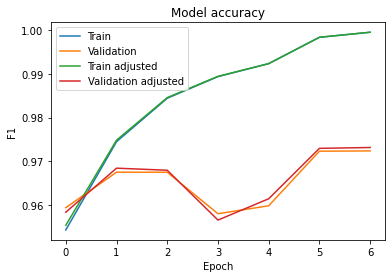

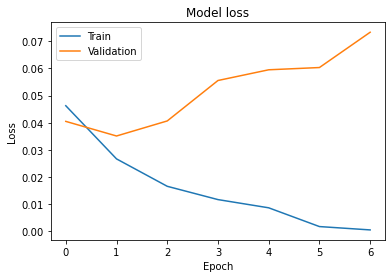

In [23]:
# plot accuracy and loss
plt.plot(F1)
plt.plot(val_F1)
plt.plot(F1_a)
plt.plot(val_F1_a)
#plt.plot(history.history['recall'])
#plt.plot(history.history['val_recall'])
plt.title('Model accuracy')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation','Train adjusted', 'Validation adjusted'], loc='upper left')
plt.savefig(target_dir + mod_name + '_acc.png')
plt.show()
plt.close()

plt.plot(loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(target_dir + mod_name + '_loss.png')
plt.show()
plt.close()

In [24]:
train_dev = {'F1':F1,'val_F1':val_F1,'F1_adjusted':F1_a,'val_F1_adjusted':val_F1_a,'loss':loss,'val_loss':val_loss}

In [25]:
import pandas as pd
df_train_dev = pd.DataFrame.from_dict(train_dev)

In [26]:
save_csv = target_dir + mod_name +'.csv'
df_train_dev.to_csv(save_csv, index=False)

## Predict on unseen data

In [242]:
iteration = 'iter_5'
source_dir = r'C:\Users\vibane\Desktop\Victor\Victor_ML\data_merged_ready'
target_dir = os.path.join(source_dir,iteration)
mod_name = 'ResNet50_'+iteration

In [243]:
model_path =  os.path.join(os.path.dirname(source_dir),mod_name+'.h5')
# r'C:\Users\vibane\Desktop\Victor\Victor_ML\RiFNetII_nr_m1_noweight.h5'
opt = Adam(lr=0.0001)
dependencies = {
    'f1_adjusted': f1_adjusted
}
loaded_model = tf.keras.models.load_model(model_path, custom_objects=dependencies, compile=False)
loaded_model.compile(loss=loss_type,
                  optimizer=opt,
                  metrics=[Precision(),Recall(),f1_adjusted], run_eagerly=True)

test_data_dir = os.path.join(target_dir, 'test')

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

print(test_generator)
print(test_generator.class_indices)

Found 25713 images belonging to 3 classes.
{'displaced': 0, 'no_fracture': 1, 'nondisplaced': 2}


In [244]:
pred= loaded_model.predict_generator(test_generator)#, nb_validation_samples // batch_size)
y_pred=np.argmax(pred,axis=1)
y_true = test_generator.classes

In [245]:
print(len(y_pred))
print(len(y_true))

25713
25713


In [246]:
from sklearn.metrics import precision_recall_fscore_support
def f1_adjusted(y_true, y_pred):
    
    p_r = precision_recall_fscore_support(y_true, y_pred, average=None,labels=[0, 1, 2])
    f_list = [ind_f_score(p_r[0][0],p_r[1][0],0.9),ind_f_score(p_r[0][1],p_r[1][1],1.2),ind_f_score(p_r[0][2],p_r[1][2],0.9)]
    f_list = [0 if x != x else x for x in f_list]
    f1 = f_final(f_list,p_r[3][0],p_r[3][1],p_r[3][2])
    
    return f1

In [247]:
score = f1_adjusted(y_true,y_pred)
print('{:.4f} F1_adjusted'.format(score))

0.9667 F1_adjusted


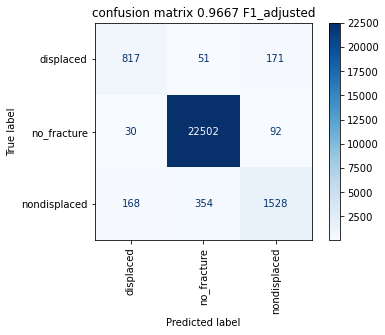

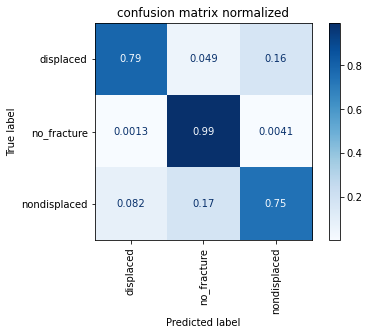

In [248]:
# calculate and plot confusion matrix

#class_labels = ['buckle','displaced','no_fracture','nondisplaced','nondisplaced_consolidated','nondisplaced_nonunion','nondisplaced_single'] 
#class_labels = ['buckle','displaced','no_fracture','nondisplaced','nondisplaced_single'] 
#class_labels = ['buckle','displaced','no_fracture','nondisplaced']
class_labels = ['displaced','no_fracture','nondisplaced'] 

mod_name = os.path.basename(model_path).split('.')[0]

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

disp.plot(cmap=plt.cm.Blues)
plt.title('confusion matrix' + ' {:.4f} F1_adjusted'.format(score))
plt.xticks(ticks=None, labels=None, rotation=90)
plt.savefig(target_dir + mod_name + '_abs.png')
plt.show()
plt.close()

cm = confusion_matrix(test_generator.classes, y_pred,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

disp.plot(cmap=plt.cm.Blues)
plt.title('confusion matrix normalized')
plt.xticks(ticks=None, labels=None, rotation=90)
plt.savefig(target_dir + mod_name + '_rel.png')
plt.show()
plt.close()

In [249]:
classes = natsorted(os.listdir(test_data_dir))
classes

['displaced', 'no_fracture', 'nondisplaced']

In [250]:
import cv2

tot_recall_classes = []
tot_recall_fractures = []
tot_missed_classes = []
tot_missed_fractures = []
tot_fractures = []
tot_scores = []
confused = []
missed = []
tot_human_scores = []
missed_human_scores = []
confused_human_scores = []

for cl in range(len(classes)):
    
    current_class = classes[cl]
    print('current class:',current_class)
    
    if classes[cl] == 'no_fracture':
        continue
        
    candidates =  natsorted(os.listdir(os.path.join(test_data_dir,classes[cl])))
    candidates = [os.path.join(test_data_dir,classes[cl],x) for x in candidates]
    cand_pack = pack(candidates)
    tot_fractures.append(len(cand_pack))
    
    missed_fractures = 0
    missed_classes = 0
    
    clean_classes = classes.copy()
    no_frac = classes.index('no_fracture')
    clean_classes.pop(no_frac)
    
    
    for i in clean_classes:
        if i != current_class:
            index_other = classes.index(i)
            
    human_scores = []
    scores = []
    for frac in cand_pack:
        
        human_score = int(frac[0].split('.')[0].split('\\')[-1][-1])
        human_scores.append(human_score)   
        frac_imgs = [cv2.imread(img, cv2.IMREAD_UNCHANGED) for img in frac]
        frac_imgs = np.array([x/255. for x in frac_imgs])
        pred = loaded_model.predict(frac_imgs)
        y_pred = list(np.argmax(pred,axis=1))
        nb_current_class = y_pred.count(cl)
        nb_other_class = y_pred.count(index_other)
        score_current_class = nb_current_class/len(frac)
        scores.append(score_current_class)
        
        if nb_other_class != 0 and (nb_current_class/nb_other_class) < 1:
            missed_name = frac[0].split('.')[0].split('\\')[-1][:-4]
            missed_human_score = frac[0].split('.')[0].split('\\')[-1][-1]
            confused.append(str(classes[cl])+'_'+missed_name)
            confused_human_scores.append(missed_human_score)
            #print('confused fracture of class "{}" for class "{}":'.format(classes[cl],classes[index_other]),missed_name)
            missed_classes += 1
        
        if nb_current_class == 0 and nb_other_class == 0:  
            missed_name = frac[0].split('.')[0].split('\\')[-1][:-4]
            missed_human_score = frac[0].split('.')[0].split('\\')[-1][-1]
            missed.append(str(classes[cl])+'_'+missed_name)
            missed_human_scores.append(missed_human_score)
            #print('entirely missed fracture of class "{}":'.format(classes[cl]),missed_name)
            missed_fractures += 1

    human_scores =[round(x/3,2) for x in human_scores]
    tot_human_scores.append(human_scores)
    recall_fractures = round(1-(missed_fractures/len(cand_pack)),4)
    tot_recall_fractures.append(recall_fractures)
    tot_missed_classes.append(missed_classes)
    recall_classes = round(1-(missed_classes/len(cand_pack)),4)
    tot_recall_classes.append(recall_classes)
    tot_scores.append(scores)
    
    r = np.corrcoef(human_scores, scores)
    corr = r[0, 1]
    print('correlation human - tool:', corr)
    print('--> Missed {} fractures entirely'.format(missed_fractures))
    print('--> Recall detecting a fracture in the class "{}":'.format(classes[cl]),recall_classes)
    
print('')
print('--> Overall fractures undetected ignoring the classes: {} of a total of: {}'.format(sum(tot_missed_fractures),sum(tot_fractures)))
print('--> Overall recall detecting a fracture ignoring the classes:',sum(tot_recall_fractures)/len(tot_recall_fractures))
print('')
print('--> Overall fractures undetected from a certain fracture type: {} of a total of: {}'.format(sum(tot_missed_classes),sum(tot_fractures)))
print('--> Overall recall detecting a certain fracture type:',sum(tot_recall_classes)/len(tot_recall_classes))




current class: displaced
correlation human - tool: 0.24973168065270593
--> Missed 0 fractures entirely
--> Recall detecting a fracture in the class "displaced": 0.8571
current class: no_fracture
current class: nondisplaced
correlation human - tool: 0.3697449588952645
--> Missed 7 fractures entirely
--> Recall detecting a fracture in the class "nondisplaced": 0.903

--> Overall fractures undetected ignoring the classes: 0 of a total of: 197
--> Overall recall detecting a fracture ignoring the classes: 0.9739

--> Overall fractures undetected from a certain fracture type: 22 of a total of: 197
--> Overall recall detecting a certain fracture type: 0.88005


In [251]:
total_fracs = sum(tot_fractures)
acc_missed = round(1-(len(missed)/total_fracs),3)
acc_confused = round(1-(len(confused)/total_fracs),3)

print('accuracy of detecting fractures:',acc_missed,'/ accuracy of detecting fracture types:', acc_confused)

accuracy of detecting fractures: 0.964 / accuracy of detecting fracture types: 0.888


In [252]:
print(missed)
print(missed_human_scores)
nb_list = [int(x) for x in missed_human_scores]
print(np.mean(nb_list))

['nondisplaced_fracture_210_5', 'nondisplaced_fracture_210_7', 'nondisplaced_fracture_210_8', 'nondisplaced_fracture_210_14', 'nondisplaced_fracture_210_31', 'nondisplaced_fracture_210_34', 'nondisplaced_fracture_211_16']
['1', '1', '1', '1', '1', '1', '1']
1.0


In [253]:
print(confused)
print(confused_human_scores)
nb_list = [int(x) for x in confused_human_scores]
print(np.mean(nb_list))

['displaced_fracture_221_4', 'displaced_fracture_229_8', 'displaced_fracture_236_4', 'displaced_fracture_241_7', 'displaced_fracture_241_8', 'displaced_fracture_242_1', 'displaced_fracture_242_12', 'displaced_fracture_242_15', 'displaced_fracture_242_17', 'nondisplaced_fracture_208_7', 'nondisplaced_fracture_208_11', 'nondisplaced_fracture_210_1', 'nondisplaced_fracture_210_11', 'nondisplaced_fracture_210_17', 'nondisplaced_fracture_210_21', 'nondisplaced_fracture_211_19', 'nondisplaced_fracture_211_25', 'nondisplaced_fracture_211_29', 'nondisplaced_fracture_217_1', 'nondisplaced_fracture_217_5', 'nondisplaced_fracture_218_5', 'nondisplaced_fracture_220_3']
['3', '3', '3', '3', '3', '2', '1', '1', '3', '2', '2', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2']
1.8636363636363635


In [254]:
nb = mod_name.split('_')[-1]
dic = {'iteration':nb,'missed':missed,'missed_score':missed_human_scores,
       'confused':confused,'confused_score':confused_human_scores,'total_fractures':total_fracs}

In [255]:
df_prediction = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in dic.items() ]))
df_prediction.head()

,iteration,missed,missed_score,confused,confused_score,total_fractures
0,5,nondisplaced_fracture_210_5,1,displaced_fracture_221_4,3,197.0
1,NaN,nondisplaced_fracture_210_7,1,displaced_fracture_229_8,3,NaN
2,NaN,nondisplaced_fracture_210_8,1,displaced_fracture_236_4,3,NaN
3,NaN,nondisplaced_fracture_210_14,1,displaced_fracture_241_7,3,NaN
4,NaN,nondisplaced_fracture_210_31,1,displaced_fracture_241_8,3,NaN


In [256]:
save_csv = target_dir + '_prediction_' + mod_name +'.csv'
df_prediction.to_csv(save_csv, index=False)

In [257]:
tot_list = [missed, missed_human_scores, confused, confused_human_scores]
names = ['missed','confused']

In [258]:
data_save_path = target_dir + '_missclassified'
if not os.path.isdir(data_save_path):
    os.makedirs(data_save_path)
    
for i in range(0,len(tot_list),2):
    
    current_accuracy_type = names[int(i/2)]
    current_path = os.path.join(data_save_path,current_accuracy_type) 
    
    if not os.path.isdir(current_path):
        os.makedirs(current_path)
        
    current_list = tot_list[i]
    current_scores = tot_list[i+1]
    
    for s in range(len(current_list)):
        
        parts =  current_list[s].split('_')
        current_class = parts[0]
        real_sample = parts[1]+'_'+parts[2]+'_'+parts[3]+'_'+'1'+'_'+current_scores[s]
        real_sample_old_path = os.path.join(test_data_dir,current_class,real_sample+'.jpg')
        real_sample_new_path = os.path.join(current_path,current_list[s]+'_'+current_scores[s]+'.jpg')
        shutil.copy(real_sample_old_path, real_sample_new_path)

Text(0.5, 0.98, 'Machine certainty distribution for each fracture class')

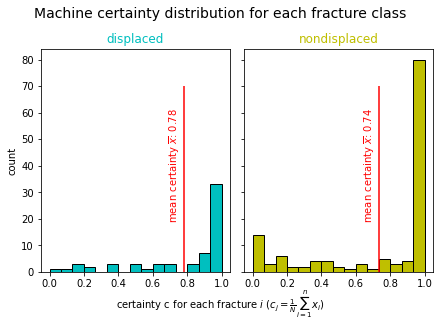

In [259]:
# plot distribution of fracture certainty for each class
n_bins = 15
fig, axs = plt.subplots(1, 2, sharey=True, constrained_layout=True)
axs[0].hist(tot_scores[0], bins=n_bins, color='c',histtype='bar', ec='black')
axs[1].hist(tot_scores[1], bins=n_bins, color='y',histtype='bar', ec='black')
axs[0].set_title(classes[0], color='c')
axs[1].set_title(classes[2], color='y')
axs[0].set_ylabel('count')
axs[0].vlines(np.mean(tot_scores[0]),0,70,color='r')
axs[1].vlines(np.mean(tot_scores[1]),0,70,color='r')
axs[0].text(np.mean(tot_scores[0])-0.1,20,'mean certainty $\overline{x}$: '+str(round(np.mean(tot_scores[0]),2)),color='r',rotation=90)
axs[1].text(np.mean(tot_scores[1])-0.1,20,'mean certainty $\overline{x}$: '+str(round(np.mean(tot_scores[1]),2)),color='r',rotation=90)
fig.text(0.5, -0.06, r'certainty c for each fracture $i$ ($c_j = \frac{1}{N} \sum_{i=1}^n x_i$)', ha='center')
fig.suptitle('Machine certainty distribution for each fracture class', fontsize=14, ha='center')


Text(0.5, 0.98, 'Human certainty distribution for each fracture class')

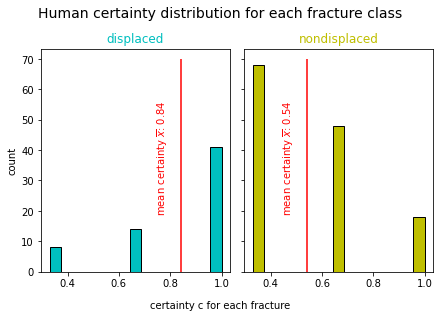

In [260]:
# plot distribution of fracture certainty for each class
n_bins = 15
fig, axs = plt.subplots(1, 2, sharey=True, constrained_layout=True)
axs[0].hist(tot_human_scores[0], bins=n_bins, color='c',histtype='bar', ec='black')
axs[1].hist(tot_human_scores[1], bins=n_bins, color='y',histtype='bar', ec='black')
axs[0].set_title(classes[0], color='c')
axs[1].set_title(classes[2], color='y')
axs[0].set_ylabel('count')
axs[0].vlines(np.mean(tot_human_scores[0]),0,70,color='r')
axs[1].vlines(np.mean(tot_human_scores[1]),0,70,color='r')
axs[0].text(np.mean(tot_human_scores[0])-0.1,20,'mean certainty $\overline{x}$: '+str(round(np.mean(tot_human_scores[0]),2)),color='r',rotation=90)
axs[1].text(np.mean(tot_human_scores[1])-0.1,20,'mean certainty $\overline{x}$: '+str(round(np.mean(tot_human_scores[1]),2)),color='r',rotation=90)
fig.text(0.5, -0.06, r'certainty c for each fracture', ha='center')
fig.suptitle('Human certainty distribution for each fracture class', fontsize=14, ha='center')

In [ ]:
cm_fr_lvl = np.array([[6,12,2,0,14],
            [8,98,8,0,17],
            [1,7,47,1,7],
            [0,0,0,0,0],
            [8,30,9,3,317]])
cm_fr_lvl_rel = np.array([[0.18,0.35,0.059,0,0.41],
            [0.061,0.75,0.061,0,0.13],
            [0.016,0.11,0.75,0.016,0.11],
            [0,0,0,0,0],
            [0.022,0.082,0.025,0.0082,0.86]])
cm_rep_lvl = np.array([[92,195,26,15,202],
            [147,1440,167,25,289],
            [29,110,612,85,120],
            [8,58,33,8632,345],
            [131,423,128,444,4506]])
cm_rep_lvl_rel = np.array([[0.17,0.37,0.049,0.028,0.38],
            [0.071,0.7,0.081,0.012,0.14],
            [0.03,0.12,0.64,0.089,0.13],
            [0.00088,0.0064,0.0036,0.95,0.038],
            [0.023,0.075,0.023,0.079,0.8]])
labels = ['D1','D2','D3','NO','ND']

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm_fr_lvl,display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.savefig(os.path.join(source_path,'ResNet50_full_model_fracture_level_abs.pdf'))

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_fr_lvl_rel,display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.savefig(os.path.join(source_path,'ResNet50_full_model_fracture_level_rel.pdf'))

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rep_lvl,display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.savefig(os.path.join(source_path,'ResNet50_full_model_representation_level_abs.pdf'))

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rep_lvl_rel,display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.savefig(os.path.join(source_path,'ResNet50_full_model_representation_level_rel.pdf'))